# Facial Expression Recognition in Real-time
Welcome to my Facial Expression Recognition project! In an age where non-verbal cues are as significant as the words we speak, understanding facial expressions becomes a crucial aspect of human-computer interaction. The primary goal of this project is to harness the power of machine learning and computer vision to recognize and classify human facial expressions in real-time.

## Overview:
Facial expressions are universal indicators of human emotions. Whether it's the evident joy in a smile or the subtle hints of surprise, our faces convey a multitude of emotions that transcend language barriers. In this project, we aim to delve deep into the world of computer vision to train a model that can accurately detect seven fundamental emotions: Happy, Sad, Angry, Surprised, Neutral, Disgusted, and Fearful.

### Key Features:
- __Data Exploration:__ Delve into the nuances of the _FER2013_ dataset, understanding its structure and the distribution of various facial expressions.
- __Model Development:__ Harness deep learning techniques by leveraging convolutional neural networks to optimize performance and generalize well on unseen data.
- __Real-time Analysis:__ Using OpenCV, capture video feed from a webcam and witness the model in action, identifying emotions on-the-fly.
- __Evaluation:__ Understand the model's strengths and weaknesses, using metrics like accuracy, precision, recall, and the F1-score.
- __Insights & Visualization:__ See which regions of a face our model focuses on to make its predictions, using techniques like Grad-CAM.

### Potential Applications:
The implications of a robust facial expression recognition system are vast:

- __Enhanced User Experience:__ Imagine video games or applications adapting in real-time to users' emotions, offering a tailored, responsive experience.
- __Mental Health Monitoring:__ Regular monitoring and analysis of a person's facial expressions could offer insights into their mental well-being.
- __Human-computer Interaction:__ Make machines more empathetic, understanding, and interactive, paving the way for truly personalized computing experiences.

## 

### Dependencies and data

In [1]:
# Import necessary libraries
import os
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Make sure kaggle is installed
# pip install kaggle

In [3]:
# Download and unzip the FER2013 dataset
kaggle.api.authenticate()
dataset_name = "deadskull7/fer2013"
kaggle.api.dataset_download_files(dataset_name, path='./', unzip=True)

print("FER2013 dataset downloaded and extracted!")

FER2013 dataset downloaded and extracted!


### 1. Load the dataset

In [4]:
# Load the dataset
data_path = "fer2013.csv"
df = pd.read_csv(data_path)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### 2. Examine the structure
The dataset has three columns:
- emotion: the emotion label.
- pixels: the pixel values for the images, space-separated.
- Usage: the purpose of this data (training, testing, validation).
Check the distribution of data across Usage:

In [5]:
print(df['Usage'].value_counts())

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


### 3. Visualize some of the images

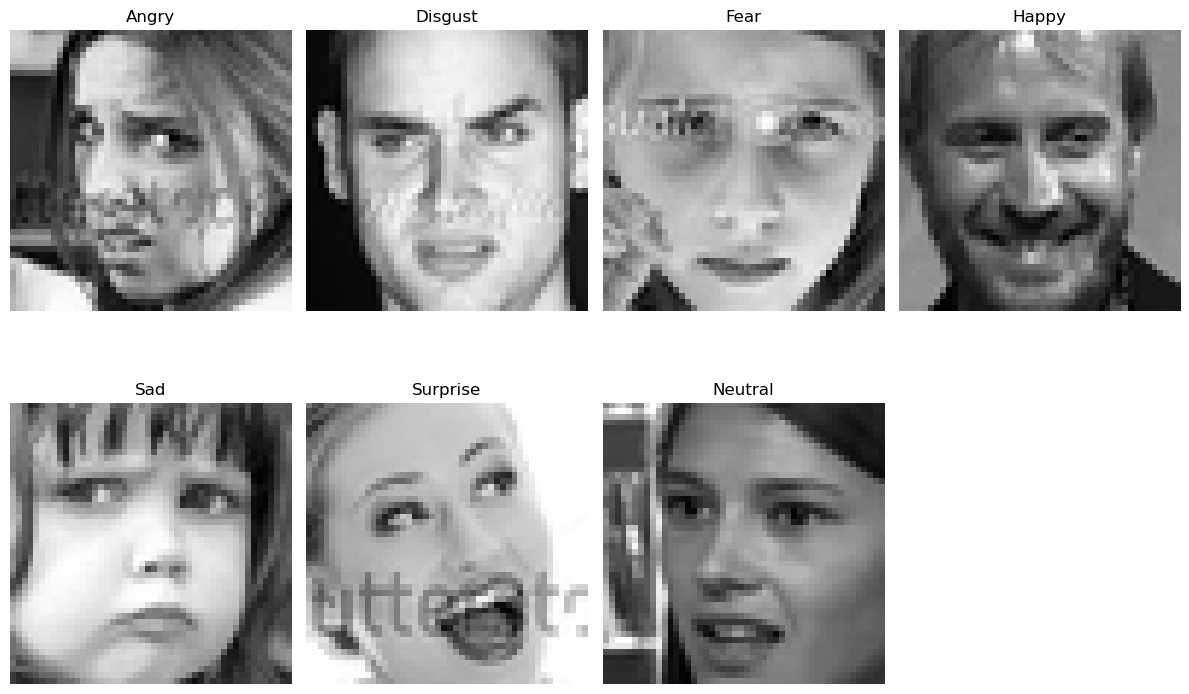

In [6]:
# Convert string pixels to numpy array
def string_to_image(pixel_string):
    pixels = np.array(pixel_string.split(' '), dtype=int)
    image = pixels.reshape(48, 48)
    return image

# Plot a random sample of images from each emotion
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(12, 8))
for i in range(7):
    plt.subplot(2, 4, i+1)
    random_sample = df[df['emotion'] == i].sample(1).iloc[0]
    image = string_to_image(random_sample['pixels'])
    plt.imshow(image, cmap='gray')
    plt.title(emotion_labels[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()


### 4. Examine the distribution of facial expressions

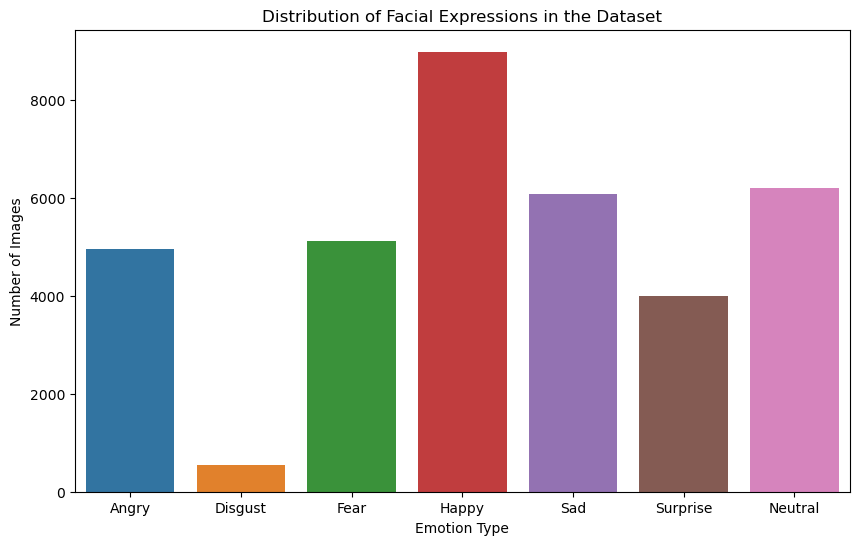

In [7]:
# Plot the distribution of the emotions
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df)
plt.title('Distribution of Facial Expressions in the Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Emotion Type')
plt.xticks(ticks=range(7), labels=emotion_labels)
plt.show()

## Datapreperations

### 1. Normalize the Images:
Neural networks tend to perform better when the input data is normalized. Given that these are grayscale images with pixel values ranging from 0 to 255, we can simply divide by 255 to scale the data to the range [0,1].

In [8]:
# Convert pixels to numpy arrays
df['pixels'] = df['pixels'].apply(lambda pixel_sequence: np.array(pixel_sequence.split(' '), dtype=float).reshape(48, 48) / 255.0)

### 2. Data Augmentation

Using data augmentation can be a good approach if you think the model might overfit. Augmentation artificially increases the size of the training dataset by applying transformations like rotation, zoom, shift, etc. Here's a basic setup using ImageDataGenerator from Keras:

In [9]:
data_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

### 3. Split the Dataset:
The FER2013 dataset provides predefined splits for training, validation, and testing. Let's utilize those:

In [10]:
# Splitting the dataset
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

X_train = np.stack(train_df['pixels'].to_numpy())
X_val = np.stack(val_df['pixels'].to_numpy())
X_test = np.stack(test_df['pixels'].to_numpy())

# We need to add an extra dimension since CNNs expect batches of multi-channel images
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train = train_df['emotion'].to_numpy()
y_val = val_df['emotion'].to_numpy()
y_test = test_df['emotion'].to_numpy()

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 28709
Validation samples: 3589
Testing samples: 3589


## Model Building

### 1. Define the CNN Architecture
 Given the nature of the problem, a Convolutional Neural Network (CNN) is well-suited for this task. We can start with a relatively simple architecture and then fine-tune or expand as necessary.

In [11]:
model = Sequential([
    # First Convolutional Layer
    Conv2D(64, (5, 5), activation='elu', input_shape=(48, 48, 1), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # Second Convolutional Layer
    Conv2D(64, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # Fourth Convolutional Layer
    Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    
    # Fifth Convolutional Layer
    Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # Sixth Convolutional Layer
    Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),

    # Flatten the results to feed into a dense layer
    Flatten(),
    
    # 128 neuron in the fully-connected layer
    Dense(256, activation='elu'),
    BatchNormalization(),
    Dropout(0.5),

    # 7 output neurons for 7 classes with the softmax activation
    Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                        

This model uses a combination of convolutional layers followed by max-pooling. Dropout layers are added to prevent overfitting, and BatchNormalization helps in accelerating the training process.

### 2. Compile the model
To prepare the model for training, we need to compile it by specifying a loss function, an optimizer, and a metric to monitor during training.

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 3. Train the Model
Now, we'll train the model. To enhance the model's ability to generalize and potentially improve its accuracy, we're utilizing data augmentation through the ImageDataGenerator we defined earlier.

During the training process, you'll observe the training and validation accuracy/loss for each epoch. To optimize our model's performance and ensure efficient training, we have incorporated both early stopping and learning rate reduction based on plateaus.

__Early Stopping:__ This is a regularization technique used during the training of a model to prevent overfitting. It monitors a specified metric (in our case, the validation loss) and halts the training process if this metric does not show improvement for a specified number of consecutive epochs. It ensures that we do not waste computational resources and time by continuing to train a model that has ceased to improve.

__ReduceLROnPlateau:__ To ensure the model converges efficiently, we've also introduced a learning rate reduction strategy. If the model's validation performance doesn't improve for a set number of epochs, the learning rate is reduced by a factor, allowing for potentially finer adjustments in the model weights. This can help the model escape local minima in the loss landscape and lead to a more optimal solution.

With these callbacks in place, the training might stop before reaching the maximum number of epochs if the model's performance on the validation set doesn't improve for the duration specified by their respective patience parameters.

In [13]:
# Training parameters
epochs = 100
batch_size = 128

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,       # Factor by which the learning rate will be reduced
    patience=5,       # Number of epochs with no improvement to wait before reducing the learning rate
    verbose=1,
    min_delta=0.0001, # Threshold for measuring the new optimum
    cooldown=2,       # Number of epochs to wait before resuming normal operation after lr has been reduced.
    min_lr=0.00001    # Lower bound on the learning rate
)

# List of callbacks
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/100
224/224 [==============================] - 556s 2s/step - loss: 2.1105 - accuracy: 0.2841 - val_loss: 1.6751 - val_accuracy: 0.3561 - lr: 0.0010
Epoch 2/100
224/224 [==============================] - 551s 2s/step - loss: 1.6324 - accuracy: 0.3808 - val_loss: 1.4328 - val_accuracy: 0.4489 - lr: 0.0010
Epoch 3/100
224/224 [==============================] - 551s 2s/step - loss: 1.4432 - accuracy: 0.4486 - val_loss: 1.3415 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 4/100
224/224 [==============================] - 552s 2s/step - loss: 1.3425 - accuracy: 0.4832 - val_loss: 1.2617 - val_accuracy: 0.5135 - lr: 0.0010
Epoch 5/100
224/224 [==============================] - 551s 2s/step - loss: 1.2860 - accuracy: 0.5134 - val_loss: 1.2437 - val_accuracy: 0.5171 - lr: 0.0010
Epoch 6/100
224/224 [==============================] - 552s 2s/step - loss: 1.2383 - accuracy: 0.5266 - val_loss: 1.2485 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 7/100
224/224 [==============================] - 557

After training, it's advisable to visualize the training history to check for overfitting and determine if further tuning is necessary.

It's worth noting that I've iteratively adjusted and refined the model architecture throughout our experimentation process to find the best-performing one. Despite these modifications, depending on the performance, there might still be room for improvement. You might need to further tweak the architecture, introduce additional regularization methods, or fine-tune hyperparameters.

Remember, the process of building a neural network is often iterative, and the journey to the optimal model may require several rounds of tuning and validation.

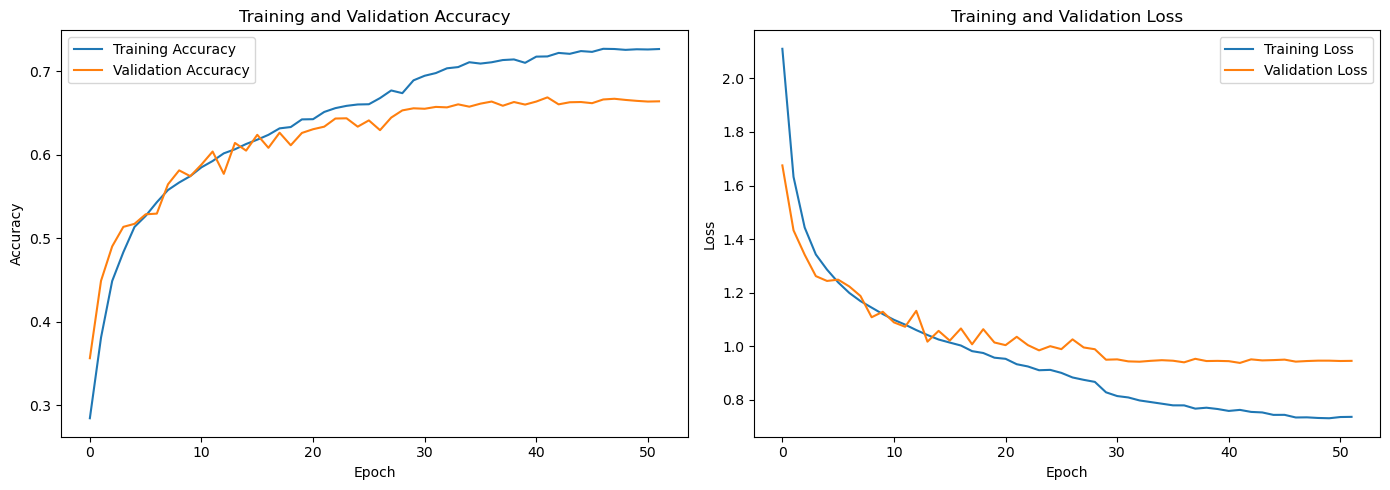

In [14]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
model.save('facial_expression_recognition_model')

INFO:tensorflow:Assets written to: facial_expression_recognition_model\assets


INFO:tensorflow:Assets written to: facial_expression_recognition_model\assets
